# Take-Home Challenge - Ultimate Technologies
## Ruth Caswell Smith

## Part 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
logins = pd.read_json('logins.json')

In [3]:
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
logins.dtypes

login_time    datetime64[ns]
dtype: object

In [5]:
logins['login_time'].isnull().sum()

0

In [6]:
logins['count']=1

In [7]:
logins.set_index('login_time', inplace=True)

In [8]:
logins_15min = logins.resample('15T').sum()

In [9]:
logins_15min.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


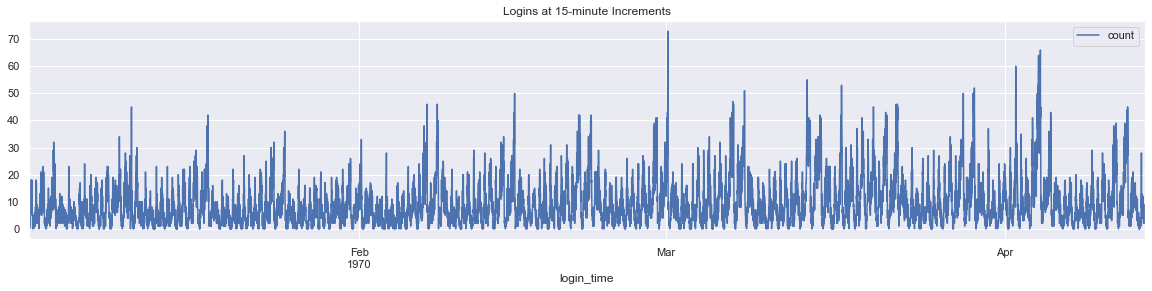

In [10]:
logins_15min.plot(figsize=(20,4))
plt.title('Logins at 15-minute Increments');

We can see that this data covers several months, and that there is strong seasonality.  In addition there are some obvious spikes. To see the seasonality more closely let's just look at two weeks of data  

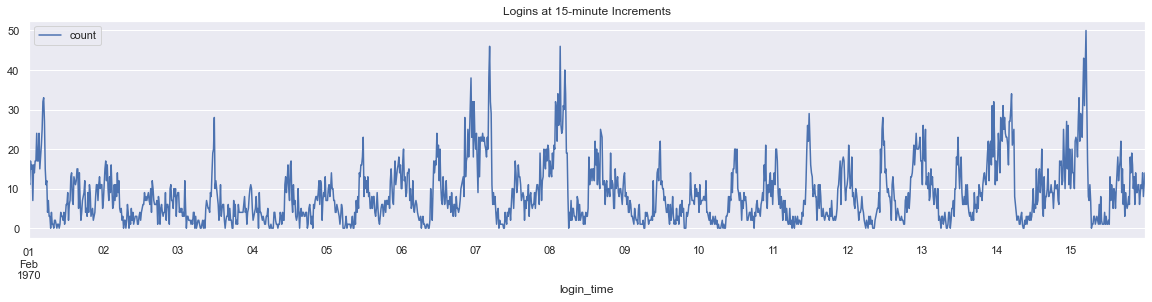

In [11]:
logins_15min.loc['1970-02-01':'1970-02-15'].plot(figsize=(20,4))
plt.title('Logins at 15-minute Increments');

We can add hour of the day and day of the week columns to our data and then do a plot.  

In [12]:
logins_15min['Day of Week']=logins_15min.index.dayofweek
logins_15min['Hour']=logins_15min.index.hour

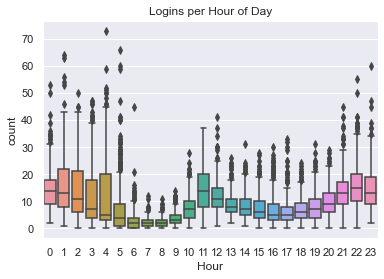

In [13]:
sns.boxplot(data=logins_15min, x='Hour', y='count')
plt.title('Logins per Hour of Day');

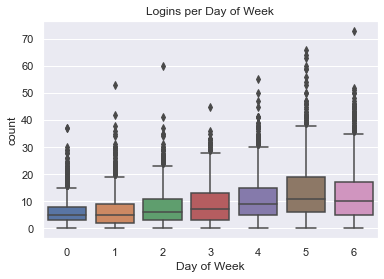

In [14]:
sns.boxplot(data=logins_15min, x='Day of Week', y='count')
plt.title('Logins per Day of Week');

We can see from these plots the patterns over the hours of the day and the days of the week.  We can also see that we have many outliers.  However I would assume that these outliers are indeed real data due to the nature of logins.  

## Part 2

1. The metric I would choose is median wait time.  Presumably with the way things are now, customers in Gotham wait longer for a driver at night, and customers in Metropolis wait longer for a driver during the day.  By encouraging driver partners to flow back and forth between cities, drivers will be able to go where the demand is, and the overall wait time at busy times should decrease.  The reason I chose this metric is because it directly relates to customer satisfcation, which should drive our business model. The reason I chose median instead of mean is that I would expect there to be some outliers in this data in terms of long wait times, but short wait times are bounded below.  

2. I would reimburse all toll costs for the period of a month.  During this time I would monitor wait times for drivers.  My null hypothesis would be that the average wait time did not change as compared with the previous month. I don't think we can assume that these distributions would be normally distributed, so I would run a permutation test.  I would randomly sample with replacement from both distributions, and calcuate the difference in medians between the two.  Then I would compare this distribution with the overall difference in medians.  I would then calculate the confidence interval that the observed difference in medians likes within the distribution of the distribution of our permutation medians.  If it does not, we can reject the null hypothesis and assume that the reimbursement of tolls impacted wait time.  If it does, we cannot assume that.  

## Part 3

### Data Wrangling

In [15]:
df = pd.read_json('ultimate_data_challenge.json')

In [16]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [18]:
# Convert dates to datetimes
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

In [19]:
# Add a column that will be our target column. We want to predict if a user is active in the sixth month, i.e.
# for users who signed up in January, this will mean that they took a trip during June.  
df['retained'] = df['last_trip_date'] > pd.to_datetime('2014-06-01')

Let's see how balanced our target variable is

In [20]:
df['retained'].value_counts()

False    31690
True     18310
Name: retained, dtype: int64

So a bit more than half our our customers are 'retained' which is good because the dataset is not horrible imbalanced.

We now need to drop last_trip_date as a feature variable becuase it directly predicts our outcome, i.e. we won't know into the future when the last time a user took a trip. 

In [21]:
df.drop(columns=['last_trip_date'], inplace=True)

Let's check out the cleanliness of our feature variables.  

In [22]:
df['city'].value_counts()

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64

That looks clean.

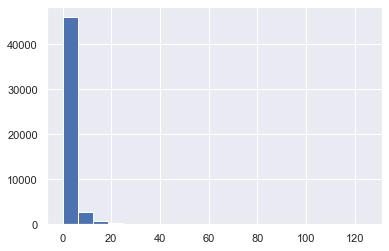

In [23]:
df['trips_in_first_30_days'].hist(bins=20);

We have some real outliers in the data, but presumably they are actual values so we'll keep them for now.  

For avg_rating_of_driver we have some null values.  Let's look at distribution

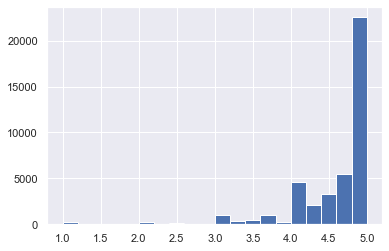

In [24]:
df['avg_rating_of_driver'].hist(bins=20);

We have a really long tail so let's replace values with the median.

In [25]:
df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].median(), inplace=True)

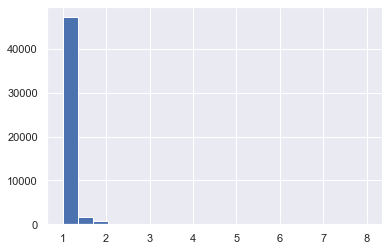

In [26]:
df['avg_surge'].hist(bins=20);

Another long tail but presumably it's real data so we'll keep it. 

In [27]:
df.phone.value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

We have some null values here, so let's assume they are iPhone since that is the more popular option.

In [28]:
df.phone.fillna('iPhone', inplace=True)

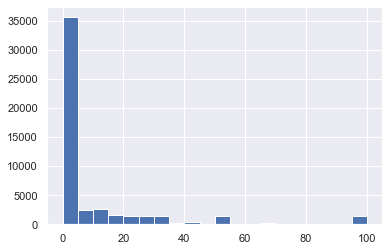

In [29]:
df.surge_pct.hist(bins=20);


Again the long tail.  

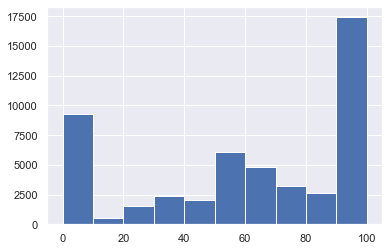

In [30]:
df.weekday_pct.hist();

That looks pretty good.

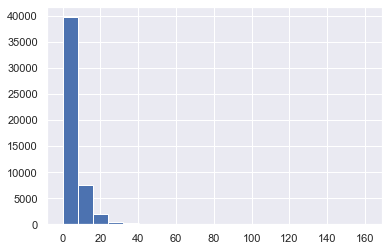

In [31]:
df.avg_dist.hist(bins=20);

Again we see some pretty extreme oultiers.  

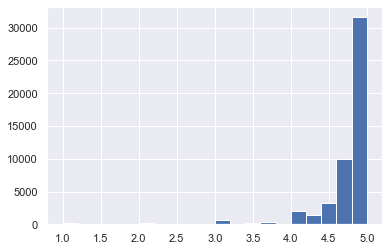

In [32]:
df.avg_rating_by_driver.hist(bins=20);

Again, we have some null values so we'll use the same strategy as for the other rating column.

In [33]:
df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].median(), inplace=True)

Ok, we've filled all of our null values, and seen what our data looks like.  We do have some extreme outliers, but since we believe they represent real values we'll build our model with them initially and then we can always tweak things later on.  

### Exploratory Data Analysis
We want to look at the correlations between our numerical features to make sure they are not highly correlated, but first let's convert our dates into something numerical.  

In [34]:
df.columns

Index(['city', 'trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'phone', 'surge_pct', 'ultimate_black_user', 'weekday_pct',
       'avg_dist', 'avg_rating_by_driver', 'retained'],
      dtype='object')

In [35]:
# Thas column will be the number of days into the month that they signed up.  
#Probably not an important feature, but you never know (mabye they were running a special)
df['signup_delta'] = df.apply(lambda x: (x['signup_date'] - pd.to_datetime('2014-01-01')).days, axis=1 )

In [36]:
# Now we can drop that column
df.drop(columns=['signup_date'], inplace=True)

In [37]:
df.columns

Index(['city', 'trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge',
       'phone', 'surge_pct', 'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver', 'retained', 'signup_delta'],
      dtype='object')

Let's create a heatmap of our numerical features

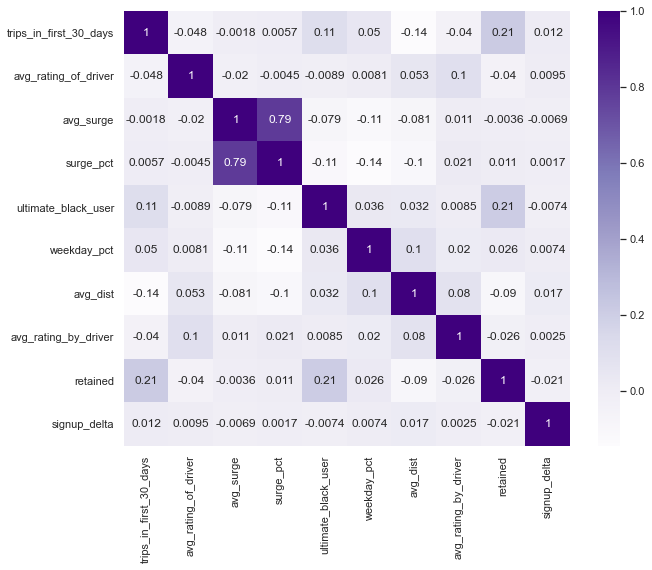

In [38]:
plt.subplots(figsize=(10,8))
sns.heatmap(df[['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge',
       'surge_pct', 'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver', 'retained', 'signup_delta']].corr(), annot=True, cmap='Purples');

The only feature variables which are highly correlated are average surge and surge percentage.  Since they are so highly correlated I choose to drop one of these.  Note that we could PCA analysis to try and come up with a set of orthogonal features, but this is complex, and we would lose the intuitive meaining of our features, so instead I will just drop a column.

In [39]:
df.drop(columns='surge_pct', inplace=True)

We can see from the heatmap that none of our numerical features seem particularly strongly correlated with retention.  Let's see about our categorical features.

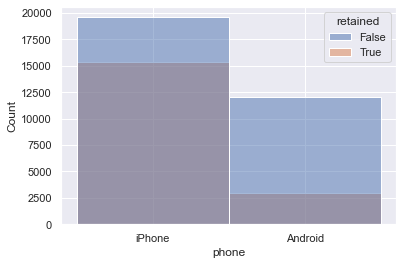

In [40]:
sns.histplot(x="phone", hue="retained",  data=df);

Interesting.  It seems a higher percentage of iPhone users are retained.  

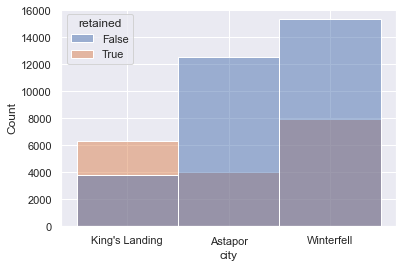

In [41]:
sns.histplot(x="city", hue="retained",  data=df);

We are definitely seeing some differences here between cities, so we would expect city to be a good predictor of retention.  

### Pre-Processing
To use a sci-kit learn classifier, we need to one-hot-encode our categorical variables.  

In [42]:
df.dtypes

city                       object
trips_in_first_30_days      int64
avg_rating_of_driver      float64
avg_surge                 float64
phone                      object
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
retained                     bool
signup_delta                int64
dtype: object

In [43]:
df_ohe = pd.get_dummies(df, drop_first = True)

In [44]:
df_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   trips_in_first_30_days  50000 non-null  int64  
 1   avg_rating_of_driver    50000 non-null  float64
 2   avg_surge               50000 non-null  float64
 3   ultimate_black_user     50000 non-null  bool   
 4   weekday_pct             50000 non-null  float64
 5   avg_dist                50000 non-null  float64
 6   avg_rating_by_driver    50000 non-null  float64
 7   retained                50000 non-null  bool   
 8   signup_delta            50000 non-null  int64  
 9   city_King's Landing     50000 non-null  uint8  
 10  city_Winterfell         50000 non-null  uint8  
 11  phone_iPhone            50000 non-null  uint8  
dtypes: bool(2), float64(5), int64(2), uint8(3)
memory usage: 2.9 MB


In [45]:
# Define X and y
X = df_ohe.drop('retained',axis = 1)
y = df_ohe['retained']

In [46]:
# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=12)

### Modeling and Training
I'm going to train a random forest classifier because they generally perform quite well.  We can also look at the feature importance of the trained model.  Also there is no need to scale the data so it's a bit simpler.  I am going to use the F1 score as my metric because I want to balance precision and recall and not just focus on accuracy.  

In [47]:
def RF_pipeline(X_train, X_test, y_train, y_test, params):
    """This runs a pipeline for Random Forest Classification using
    the f1 score as the metric for optimizing the classifier"""
    
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train).ravel()
    y_test = np.array(y_test).ravel()
        
    # Setup the pipeline
    steps = [('RF', RandomForestClassifier())]
    pipeline = Pipeline(steps)

    # Instantiate the GridSearchCV object: cv
    cv = GridSearchCV(pipeline, params, cv=5, scoring='f1')

    # Fit to the training set
    cv.fit(X_train, y_train)

    # Predict our test data
    y_pred = cv.predict(X_test)

    # Compute and print metrics
    print(classification_report(y_test, y_pred))
    print("Tuned Model Parameters: {}".format(cv.best_params_))
    print("\nConfusion Matrix: \n", confusion_matrix(y_test, y_pred))

In [48]:
# Specify the hyperparameter space
parameters = { 'RF__max_depth': [3, 5, 7], \
              'RF__criterion': ['entropy', 'gini'], 'RF__n_estimators': [100, 200]}   

RF_pipeline(X_train, X_test, y_train, y_test, parameters)

              precision    recall  f1-score   support

       False       0.80      0.87      0.83      6339
        True       0.73      0.62      0.67      3661

    accuracy                           0.78     10000
   macro avg       0.77      0.74      0.75     10000
weighted avg       0.77      0.78      0.77     10000

Tuned Model Parameters: {'RF__criterion': 'entropy', 'RF__max_depth': 7, 'RF__n_estimators': 200}

Confusion Matrix: 
 [[5515  824]
 [1400 2261]]


In [49]:
# Note that our max_depth was 7 and nunmber of estimators our max, so let's fiddle with hyperspace a bit and try again.  
# Specify the hyperparameter space
parameters = { 'RF__max_depth': [5, 7, 9], \
              'RF__criterion': ['entropy', 'gini'], 'RF__n_estimators': [200,300]}   

RF_pipeline(X_train, X_test, y_train, y_test, parameters)

              precision    recall  f1-score   support

       False       0.81      0.87      0.84      6339
        True       0.73      0.64      0.69      3661

    accuracy                           0.78     10000
   macro avg       0.77      0.75      0.76     10000
weighted avg       0.78      0.78      0.78     10000

Tuned Model Parameters: {'RF__criterion': 'gini', 'RF__max_depth': 9, 'RF__n_estimators': 200}

Confusion Matrix: 
 [[5490  849]
 [1311 2350]]


We can see that our scores were slightly different for these values, i.e. recall slightly lower and precision slightly higher.  Overall the accuracy was slightly higher, so let's use these hyperparameters to train our final model.  

In [50]:
# Let's train our final model on all the training data and see how it does against the test data

RF = RandomForestClassifier(max_depth= 9, criterion = 'gini', n_estimators = 300)  
final_model = RF.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix: \n", confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.81      0.86      0.84      6339
        True       0.73      0.64      0.69      3661

    accuracy                           0.78     10000
   macro avg       0.77      0.75      0.76     10000
weighted avg       0.78      0.78      0.78     10000


Confusion Matrix: 
 [[5483  856]
 [1308 2353]]


Let's look at our feature importance. 

In [51]:
feature_importances = pd.DataFrame(final_model.feature_importances_, index = list(X_train.columns), \
                                   columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

                        importance
avg_rating_by_driver      0.229875
city_King's Landing       0.165656
avg_surge                 0.135087
weekday_pct               0.131261
phone_iPhone              0.093440
ultimate_black_user       0.072612
trips_in_first_30_days    0.065218
avg_dist                  0.039900
avg_rating_of_driver      0.032091
signup_delta              0.021500
city_Winterfell           0.013359


### Conclusions

We have developed a random forest classifier which can predict with 79% accuracy whether a user will be retained in six months based on various features.  I should mention that I also trained a Logistic Regression model but it did not perform as well as the random forest classifier so I removed it from this notebook.  

One concern I have is that there were limitations with the data provided.  In reality, if we were provided with more data and not just a snapshot in time, we could use the date of the user's last trip as a predictive feature.  I would imagine that this would be a powerful predictor and we could improve the performance of our model given that data.  

In terms of insights, it is clear that there are some predictive features over which Ultimate has no control, for instance whether or not a user has an iPhone or not.  Presumably they could market more to iPhone users if they wanted to, however.  

This model also shows a marked difference between the various cities, and so Ultimate might want to gather some additional data to discover why they are more likely to have higher retention in certain cities than other.  Perhaps there are issues with wait times that could be addressed, so that retention could be improved.  

By far the most important feature is the rating of the user by the drivers.  This is an interesting finding and without more domain knowledge I'm not really clear what to make of it.  Definitely worth some more investigation!  

Interesting enough, there are features which I would have thought to be important but which are less important, such as whether the user took an Ultimate Black in their first thirty days, or how many trips they took in their first 30 days, or how far their average trip is.  

So we've gotten a decent model and some good information, but of course there is always more work that could be done. 